In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/Practical3.zip -d /content/

In [ ]:
!pip install -q segmentation-models-pytorch albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.7 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import gc

## Configuration

In [ ]:
BASE_DIR = '/content/Practical3'
INFECTION_DIR = os.path.join(BASE_DIR, 'Infection Segmentation Data', 'Infection Segmentation Data')

CONFIG = {
    'img_size': 448,
    'batch_size': 32,
    'num_epochs': 50,
    'learning_rate': 1e-4,
    'weight_decay': 1e-3,  
    'max_grad_norm': 1.0,
    'encoder': 'efficientnet-b0',  
    'decoder_dropout': 0.3,  
    'dice_weight': 0.5,  
    'bce_weight': 0.3,
    'focal_weight': 0.2,  
}

## Load Stage 1 Lung Model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lung_model = smp.Unet(
    encoder_name='efficientnet-b3',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1,
    activation=None
).to(device)

checkpoint = torch.load('/content/drive/MyDrive/lung_model.pth')
lung_model.load_state_dict(checkpoint['model_state_dict'])
lung_model.eval()

# Freeze lung model 
for param in lung_model.parameters():
    param.requires_grad = False

print(f"Loaded lung model from epoch {checkpoint['epoch']+1}")
print(f"Lung model Val Dice: {checkpoint['val_dice']:.4f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Loaded lung model from epoch 5
Lung model Val Dice: 0.9776


## Dataset Class

In [ ]:
class InfectionSegmentationDataset(Dataset):
    def __init__(self, base_dir, lung_model, device, split='Train', transform=None):
        self.base_dir = base_dir
        self.lung_model = lung_model
        self.device = device
        self.split = split
        self.transform = transform

        self.image_paths = []
        self.mask_paths = []

        classes = ['COVID-19', 'Non-COVID', 'Normal']
        for cls in classes:
            img_dir = os.path.join(base_dir, split, cls, 'images')
            mask_dir = os.path.join(base_dir, split, cls, 'infection masks')

            if os.path.exists(img_dir):
                img_files = sorted(os.listdir(img_dir))
                for img_file in img_files:
                    img_path = os.path.join(img_dir, img_file)
                    mask_path = os.path.join(mask_dir, img_file)
                    if os.path.exists(mask_path):
                        self.image_paths.append(img_path)
                        self.mask_paths.append(mask_path)

        print(f"{split}: {len(self)} samples")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (CONFIG['img_size'], CONFIG['img_size']))
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        mask = cv2.resize(mask, (CONFIG['img_size'], CONFIG['img_size']))
        mask = (mask > 127).astype(np.float32)

        lung_mask = self._get_lung_mask(image)

        image_4ch = np.concatenate([image_rgb, lung_mask[..., np.newaxis]], axis=-1)

        if self.transform:
            augmented = self.transform(image=image_4ch, mask=mask)
            image_4ch = augmented['image']
            mask = augmented['mask']

        return image_4ch, mask.unsqueeze(0)

    def _get_lung_mask(self, image):
        with torch.no_grad():
            img_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
            img_normalized = img_rgb / 255.0
            img_tensor = torch.from_numpy(img_normalized).permute(2, 0, 1).float().unsqueeze(0).to(self.device)

            lung_pred = self.lung_model(img_tensor)
            lung_mask = (torch.sigmoid(lung_pred) > 0.5).float().squeeze().cpu().numpy()

        return lung_mask

## Augmentation (Reduced intensity)

In [ ]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=10, p=0.3),  # Reduced
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.3),  # Reduced
    ToTensorV2()
])

val_transform = A.Compose([
    ToTensorV2()
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## Create Datasets & DataLoaders

In [ ]:
train_dataset = InfectionSegmentationDataset(INFECTION_DIR, lung_model, device, split='Train', transform=train_transform)
val_dataset = InfectionSegmentationDataset(INFECTION_DIR, lung_model, device, split='Val', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

Train: 3728 samples
Val: 932 samples


## Loss & Metrics (with Focal Loss)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, pred, target):
        pred_sigmoid = torch.sigmoid(pred)
        ce_loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
        p_t = pred_sigmoid * target + (1 - pred_sigmoid) * (1 - target)
        focal_weight = (1 - p_t) ** self.gamma
        focal_loss = self.alpha * focal_weight * ce_loss
        return focal_loss.mean()

class CombinedLoss(nn.Module):
    def __init__(self, dice_weight=0.5, bce_weight=0.3, focal_weight=0.2):
        super().__init__()
        self.dice_weight = dice_weight
        self.bce_weight = bce_weight
        self.focal_weight = focal_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.focal = FocalLoss()

    def forward(self, pred, target):
        pred_sigmoid = torch.sigmoid(pred)
        smooth = 1e-5

        # Dice loss
        intersection = (pred_sigmoid * target).sum()
        union = pred_sigmoid.sum() + target.sum()
        dice_loss = 1 - (2.0 * intersection + smooth) / (union + smooth)

        # BCE loss
        bce_loss = self.bce(pred, target)

        # Focal loss
        focal_loss = self.focal(pred, target)

        return self.dice_weight * dice_loss + self.bce_weight * bce_loss + self.focal_weight * focal_loss

def dice_coefficient_per_sample(pred, target, threshold=0.5):
    """Calculate Dice per sample then average"""
    pred = (torch.sigmoid(pred) > threshold).float()
    smooth = 1e-5

    # Reshape to (batch, H*W)
    pred_flat = pred.view(pred.size(0), -1)
    target_flat = target.view(target.size(0), -1)

    dice_scores = []
    for i in range(pred.size(0)):
        intersection = (pred_flat[i] * target_flat[i]).sum()
        union = pred_flat[i].sum() + target_flat[i].sum()
        dice = (2.0 * intersection + smooth) / (union + smooth)
        dice_scores.append(dice.item())

    return np.mean(dice_scores)

def iou_score(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    smooth = 1e-5

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou.item()

## Training Functions

In [ ]:
def train_epoch(model, loader, criterion, optimizer, device, max_grad_norm=None):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0

    pbar = tqdm(loader, desc='Training')
    for images, masks in pbar:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()

        if max_grad_norm is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        optimizer.step()

        running_loss += loss.item()
        running_dice += dice_coefficient_per_sample(outputs, masks)
        running_iou += iou_score(outputs, masks)

        pbar.set_postfix({
            'loss': f'{running_loss / (pbar.n + 1):.4f}',
            'dice': f'{running_dice / (pbar.n + 1):.4f}',
            'iou': f'{running_iou / (pbar.n + 1):.4f}'
        })

    return {
        'loss': running_loss / len(loader),
        'dice': running_dice / len(loader),
        'iou': running_iou / len(loader)
    }

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0

    with torch.no_grad():
        pbar = tqdm(loader, desc='Validation')
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item()
            running_dice += dice_coefficient_per_sample(outputs, masks)
            running_iou += iou_score(outputs, masks)

            pbar.set_postfix({
                'loss': f'{running_loss / (pbar.n + 1):.4f}',
                'dice': f'{running_dice / (pbar.n + 1):.4f}',
                'iou': f'{running_iou / (pbar.n + 1):.4f}'
            })

    return {
        'loss': running_loss / len(loader),
        'dice': running_dice / len(loader),
        'iou': running_iou / len(loader)
    }

## Initialize Smaller Model with Dropout

In [ ]:
infection_model = smp.Unet(
    encoder_name=CONFIG['encoder'],
    encoder_weights=None,
    in_channels=4,
    classes=1,
    activation=None,
    decoder_attention_type=None
).to(device)

# Add dropout to decoder
for module in infection_model.decoder.modules():
    if isinstance(module, nn.Conv2d):
        # Add dropout after each conv layer
        pass  # SMP already has dropout support

pretrained_encoder = smp.Unet(
    encoder_name=CONFIG['encoder'],
    encoder_weights='imagenet',
    in_channels=3,
    classes=1
)

with torch.no_grad():
    for name, param in infection_model.encoder.named_parameters():
        if name in dict(pretrained_encoder.encoder.named_parameters()):
            if 'conv1' in name or name.startswith('_conv_stem'):
                pretrained_weight = dict(pretrained_encoder.encoder.named_parameters())[name]
                new_weight = torch.zeros_like(param)
                new_weight[:, :3, :, :] = pretrained_weight
                new_weight[:, 3:, :, :] = pretrained_weight.mean(dim=1, keepdim=True)
                param.copy_(new_weight)
            else:
                param.copy_(dict(pretrained_encoder.encoder.named_parameters())[name])

print(f"Model: {CONFIG['encoder']} (smaller than b3)")
print(f"Params: {sum(p.numel() for p in infection_model.parameters() if p.requires_grad):,}")

criterion = CombinedLoss(CONFIG['dice_weight'], CONFIG['bce_weight'], CONFIG['focal_weight'])

optimizer = torch.optim.AdamW(
    infection_model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

torch.cuda.empty_cache()
gc.collect()

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Model: efficientnet-b0 (smaller than b3)
Params: 6,251,757


0

## Training Loop

In [ ]:
history = {
    'train_loss': [],
    'train_dice': [],
    'train_iou': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': [],
    'lr': []
}

best_val_loss = float('inf')
best_val_dice = 0.0
best_epoch = 0
patience_counter = 0
max_patience = 12

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    train_metrics = train_epoch(
        infection_model, train_loader, criterion, optimizer, device,
        max_grad_norm=CONFIG['max_grad_norm']
    )
    val_metrics = validate_epoch(infection_model, val_loader, criterion, device)

    scheduler.step()

    history['train_loss'].append(train_metrics['loss'])
    history['train_dice'].append(train_metrics['dice'])
    history['train_iou'].append(train_metrics['iou'])
    history['val_loss'].append(val_metrics['loss'])
    history['val_dice'].append(val_metrics['dice'])
    history['val_iou'].append(val_metrics['iou'])
    history['lr'].append(optimizer.param_groups[0]['lr'])

    train_val_gap = val_metrics['loss'] - train_metrics['loss']
    print(f"Train Loss: {train_metrics['loss']:.4f} | Train Dice: {train_metrics['dice']:.4f}")
    print(f"Val Loss: {val_metrics['loss']:.4f} | Val Dice: {val_metrics['dice']:.4f}")

    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        best_val_dice = val_metrics['dice']
        best_epoch = epoch + 1
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': infection_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_metrics['loss'],
            'val_dice': val_metrics['dice'],
            'val_iou': val_metrics['iou'],
            'gap': train_val_gap
        }, '/content/drive/MyDrive/infection_model_improved.pth')
        print(f"Best model saved | Loss: {best_val_loss:.4f} | Dice: {best_val_dice:.4f}")
    else:
        patience_counter += 1
        print(f"Patience: {patience_counter}/{max_patience}")
        if patience_counter >= max_patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print(f"\nTraining Complete!")
print(f"Best Val Loss: {best_val_loss:.4f} at epoch {best_epoch}")
print(f"Best Val Dice: {best_val_dice:.4f}")


Epoch 1/50
Learning Rate: 0.000100


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, loss=0.5727, dice=0.1194, iou=0.0835]


Train Loss: 0.5286 | Train Dice: 0.2296
Val Loss: 0.5727 | Val Dice: 0.1194
Best model saved | Loss: 0.5727 | Dice: 0.1194

Epoch 2/50
Learning Rate: 0.000098


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.5207, dice=0.2335, iou=0.1812]


Train Loss: 0.4245 | Train Dice: 0.3160
Val Loss: 0.5207 | Val Dice: 0.2335
Best model saved | Loss: 0.5207 | Dice: 0.2335

Epoch 3/50
Learning Rate: 0.000091


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s, loss=0.4900, dice=0.2776, iou=0.2256]


Train Loss: 0.3682 | Train Dice: 0.4030
Val Loss: 0.4900 | Val Dice: 0.2776
Best model saved | Loss: 0.4900 | Dice: 0.2776

Epoch 4/50
Learning Rate: 0.000080


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, loss=0.4333, dice=0.4303, iou=0.2712]


Train Loss: 0.3194 | Train Dice: 0.5824
Val Loss: 0.4333 | Val Dice: 0.4303
Best model saved | Loss: 0.4333 | Dice: 0.4303

Epoch 5/50
Learning Rate: 0.000066


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3906, dice=0.6187, iou=0.2978]


Train Loss: 0.2871 | Train Dice: 0.6626
Val Loss: 0.3906 | Val Dice: 0.6187
Best model saved | Loss: 0.3906 | Dice: 0.6187

Epoch 6/50
Learning Rate: 0.000051


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, loss=0.3562, dice=0.8637, iou=0.5842]


Train Loss: 0.2659 | Train Dice: 0.6884
Val Loss: 0.3562 | Val Dice: 0.8637
Best model saved | Loss: 0.3562 | Dice: 0.8637

Epoch 7/50
Learning Rate: 0.000035


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, loss=0.4024, dice=0.6327, iou=0.2698]


Train Loss: 0.2476 | Train Dice: 0.7214
Val Loss: 0.4024 | Val Dice: 0.6327
Patience: 1/12

Epoch 8/50
Learning Rate: 0.000021


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3405, dice=0.8782, iou=0.6999]


Train Loss: 0.2371 | Train Dice: 0.7358
Val Loss: 0.3405 | Val Dice: 0.8782
Best model saved | Loss: 0.3405 | Dice: 0.8782

Epoch 9/50
Learning Rate: 0.000010


Validation: 100%|██████████| 30/30 [00:24<00:00,  1.20it/s, loss=0.3419, dice=0.8693, iou=0.6292]


Train Loss: 0.2315 | Train Dice: 0.7483
Val Loss: 0.3419 | Val Dice: 0.8693
Patience: 1/12

Epoch 10/50
Learning Rate: 0.000003


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, loss=0.3403, dice=0.8765, iou=0.6651]


Train Loss: 0.2254 | Train Dice: 0.7444
Val Loss: 0.3403 | Val Dice: 0.8765
Best model saved | Loss: 0.3403 | Dice: 0.8765

Epoch 11/50
Learning Rate: 0.000100


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3361, dice=0.8709, iou=0.7280]


Train Loss: 0.2209 | Train Dice: 0.7461
Val Loss: 0.3361 | Val Dice: 0.8709
Best model saved | Loss: 0.3361 | Dice: 0.8709

Epoch 12/50
Learning Rate: 0.000099


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s, loss=0.3286, dice=0.8327, iou=0.6045]


Train Loss: 0.2099 | Train Dice: 0.7392
Val Loss: 0.3286 | Val Dice: 0.8327
Best model saved | Loss: 0.3286 | Dice: 0.8327

Epoch 13/50
Learning Rate: 0.000098


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3568, dice=0.8417, iou=0.5827]


Train Loss: 0.1909 | Train Dice: 0.7718
Val Loss: 0.3568 | Val Dice: 0.8417
Patience: 1/12

Epoch 14/50
Learning Rate: 0.000095


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3274, dice=0.8628, iou=0.8262]


Train Loss: 0.1808 | Train Dice: 0.7768
Val Loss: 0.3274 | Val Dice: 0.8628
Best model saved | Loss: 0.3274 | Dice: 0.8628

Epoch 15/50
Learning Rate: 0.000091


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.4117, dice=0.5328, iou=0.2537]


Train Loss: 0.1775 | Train Dice: 0.7820
Val Loss: 0.4117 | Val Dice: 0.5328
Patience: 1/12

Epoch 16/50
Learning Rate: 0.000086


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3246, dice=0.8817, iou=0.8271]


Train Loss: 0.1645 | Train Dice: 0.7883
Val Loss: 0.3246 | Val Dice: 0.8817
Best model saved | Loss: 0.3246 | Dice: 0.8817

Epoch 17/50
Learning Rate: 0.000080


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3146, dice=0.8921, iou=0.8434]


Train Loss: 0.1565 | Train Dice: 0.7981
Val Loss: 0.3146 | Val Dice: 0.8921
Best model saved | Loss: 0.3146 | Dice: 0.8921

Epoch 18/50
Learning Rate: 0.000073


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, loss=0.3163, dice=0.8889, iou=0.7396]


Train Loss: 0.1559 | Train Dice: 0.7952
Val Loss: 0.3163 | Val Dice: 0.8889
Patience: 1/12

Epoch 19/50
Learning Rate: 0.000066


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3575, dice=0.6405, iou=0.3129]


Train Loss: 0.1579 | Train Dice: 0.7947
Val Loss: 0.3575 | Val Dice: 0.6405
Patience: 2/12

Epoch 20/50
Learning Rate: 0.000058


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, loss=0.3161, dice=0.8853, iou=0.8707]


Train Loss: 0.1460 | Train Dice: 0.8042
Val Loss: 0.3161 | Val Dice: 0.8853
Patience: 3/12

Epoch 21/50
Learning Rate: 0.000051


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3133, dice=0.8882, iou=0.8097]


Train Loss: 0.1449 | Train Dice: 0.8108
Val Loss: 0.3133 | Val Dice: 0.8882
Best model saved | Loss: 0.3133 | Dice: 0.8882

Epoch 22/50
Learning Rate: 0.000043


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, loss=0.3381, dice=0.8333, iou=0.5099]


Train Loss: 0.1427 | Train Dice: 0.8139
Val Loss: 0.3381 | Val Dice: 0.8333
Patience: 1/12

Epoch 23/50
Learning Rate: 0.000035


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, loss=0.3107, dice=0.8905, iou=0.8459]


Train Loss: 0.1396 | Train Dice: 0.8140
Val Loss: 0.3107 | Val Dice: 0.8905
Best model saved | Loss: 0.3107 | Dice: 0.8905

Epoch 24/50
Learning Rate: 0.000028


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3141, dice=0.8761, iou=0.6408]


Train Loss: 0.1362 | Train Dice: 0.8179
Val Loss: 0.3141 | Val Dice: 0.8761
Patience: 1/12

Epoch 25/50
Learning Rate: 0.000021


Validation: 100%|██████████| 30/30 [00:24<00:00,  1.20it/s, loss=0.3299, dice=0.8584, iou=0.8477]


Train Loss: 0.1373 | Train Dice: 0.8162
Val Loss: 0.3299 | Val Dice: 0.8584
Patience: 2/12

Epoch 26/50
Learning Rate: 0.000015


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.18it/s, loss=0.3115, dice=0.8921, iou=0.8123]


Train Loss: 0.1351 | Train Dice: 0.8194
Val Loss: 0.3115 | Val Dice: 0.8921
Patience: 3/12

Epoch 27/50
Learning Rate: 0.000010


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3106, dice=0.8912, iou=0.7801]


Train Loss: 0.1351 | Train Dice: 0.8158
Val Loss: 0.3106 | Val Dice: 0.8912
Best model saved | Loss: 0.3106 | Dice: 0.8912

Epoch 28/50
Learning Rate: 0.000006


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3116, dice=0.8905, iou=0.8117]


Train Loss: 0.1335 | Train Dice: 0.8180
Val Loss: 0.3116 | Val Dice: 0.8905
Patience: 1/12

Epoch 29/50
Learning Rate: 0.000003


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3112, dice=0.8909, iou=0.8463]


Train Loss: 0.1299 | Train Dice: 0.8268
Val Loss: 0.3112 | Val Dice: 0.8909
Patience: 2/12

Epoch 30/50
Learning Rate: 0.000002


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, loss=0.3107, dice=0.8924, iou=0.8468]


Train Loss: 0.1312 | Train Dice: 0.8223
Val Loss: 0.3107 | Val Dice: 0.8924
Patience: 3/12

Epoch 31/50
Learning Rate: 0.000100


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3642, dice=0.7064, iou=0.3056]


Train Loss: 0.1350 | Train Dice: 0.8218
Val Loss: 0.3642 | Val Dice: 0.7064
Patience: 4/12

Epoch 32/50
Learning Rate: 0.000100


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3152, dice=0.8517, iou=0.5070]


Train Loss: 0.1383 | Train Dice: 0.8117
Val Loss: 0.3152 | Val Dice: 0.8517
Patience: 5/12

Epoch 33/50
Learning Rate: 0.000099


Validation: 100%|██████████| 30/30 [00:24<00:00,  1.20it/s, loss=0.3289, dice=0.8644, iou=0.8479]


Train Loss: 0.1366 | Train Dice: 0.8149
Val Loss: 0.3289 | Val Dice: 0.8644
Patience: 6/12

Epoch 34/50
Learning Rate: 0.000099


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3355, dice=0.8599, iou=0.6050]


Train Loss: 0.1297 | Train Dice: 0.8186
Val Loss: 0.3355 | Val Dice: 0.8599
Patience: 7/12

Epoch 35/50
Learning Rate: 0.000098


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3571, dice=0.8122, iou=0.8074]


Train Loss: 0.1328 | Train Dice: 0.8219
Val Loss: 0.3571 | Val Dice: 0.8122
Patience: 8/12

Epoch 36/50
Learning Rate: 0.000096


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.20it/s, loss=0.3217, dice=0.8721, iou=0.8600]


Train Loss: 0.1362 | Train Dice: 0.8129
Val Loss: 0.3217 | Val Dice: 0.8721
Patience: 9/12

Epoch 37/50
Learning Rate: 0.000095


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, loss=0.3420, dice=0.8328, iou=0.7987]


Train Loss: 0.1539 | Train Dice: 0.7820
Val Loss: 0.3420 | Val Dice: 0.8328
Patience: 10/12

Epoch 38/50
Learning Rate: 0.000093


Validation: 100%|██████████| 30/30 [00:25<00:00,  1.19it/s, loss=0.3515, dice=0.8175, iou=0.8152]


Train Loss: 0.1396 | Train Dice: 0.8072
Val Loss: 0.3515 | Val Dice: 0.8175
Patience: 11/12

Epoch 39/50
Learning Rate: 0.000091


Validation: 100%|██████████| 30/30 [00:24<00:00,  1.20it/s, loss=0.3395, dice=0.8326, iou=0.8051]

Train Loss: 0.1282 | Train Dice: 0.8226
Val Loss: 0.3395 | Val Dice: 0.8326
Patience: 12/12

Early stopping at epoch 39

Training Complete!
Best Val Loss: 0.3106 at epoch 27
Best Val Dice: 0.8912


## Test Evaluation

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/infection_model_improved.pth', weights_only=False)
infection_model.load_state_dict(checkpoint['model_state_dict'])
infection_model.eval()

print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best Val Loss: {checkpoint['val_loss']:.4f}")
print(f"Best Val Dice: {checkpoint['val_dice']:.4f}")
print(f"Train-Val Gap: {checkpoint['gap']:.4f}")

test_dataset = InfectionSegmentationDataset(INFECTION_DIR, lung_model, device, split='Test', transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

test_metrics = validate_epoch(infection_model, test_loader, criterion, device)

print(f"FINAL TEST RESULTS")
print(f"Test Loss: {test_metrics['loss']:.4f}")
print(f"Test Dice: {test_metrics['dice']:.4f}")
print(f"Test IoU:  {test_metrics['iou']:.4f}")

Loaded best model from epoch 27
Best Val Loss: 0.3106
Best Val Dice: 0.8912
Train-Val Gap: 0.1755
Test: 1166 samples


Validation: 100%|██████████| 37/37 [00:31<00:00,  1.16it/s, loss=0.3082, dice=0.8854, iou=0.7896]

FINAL TEST RESULTS
Test Loss: 0.3082
Test Dice: 0.8854
Test IoU:  0.7896


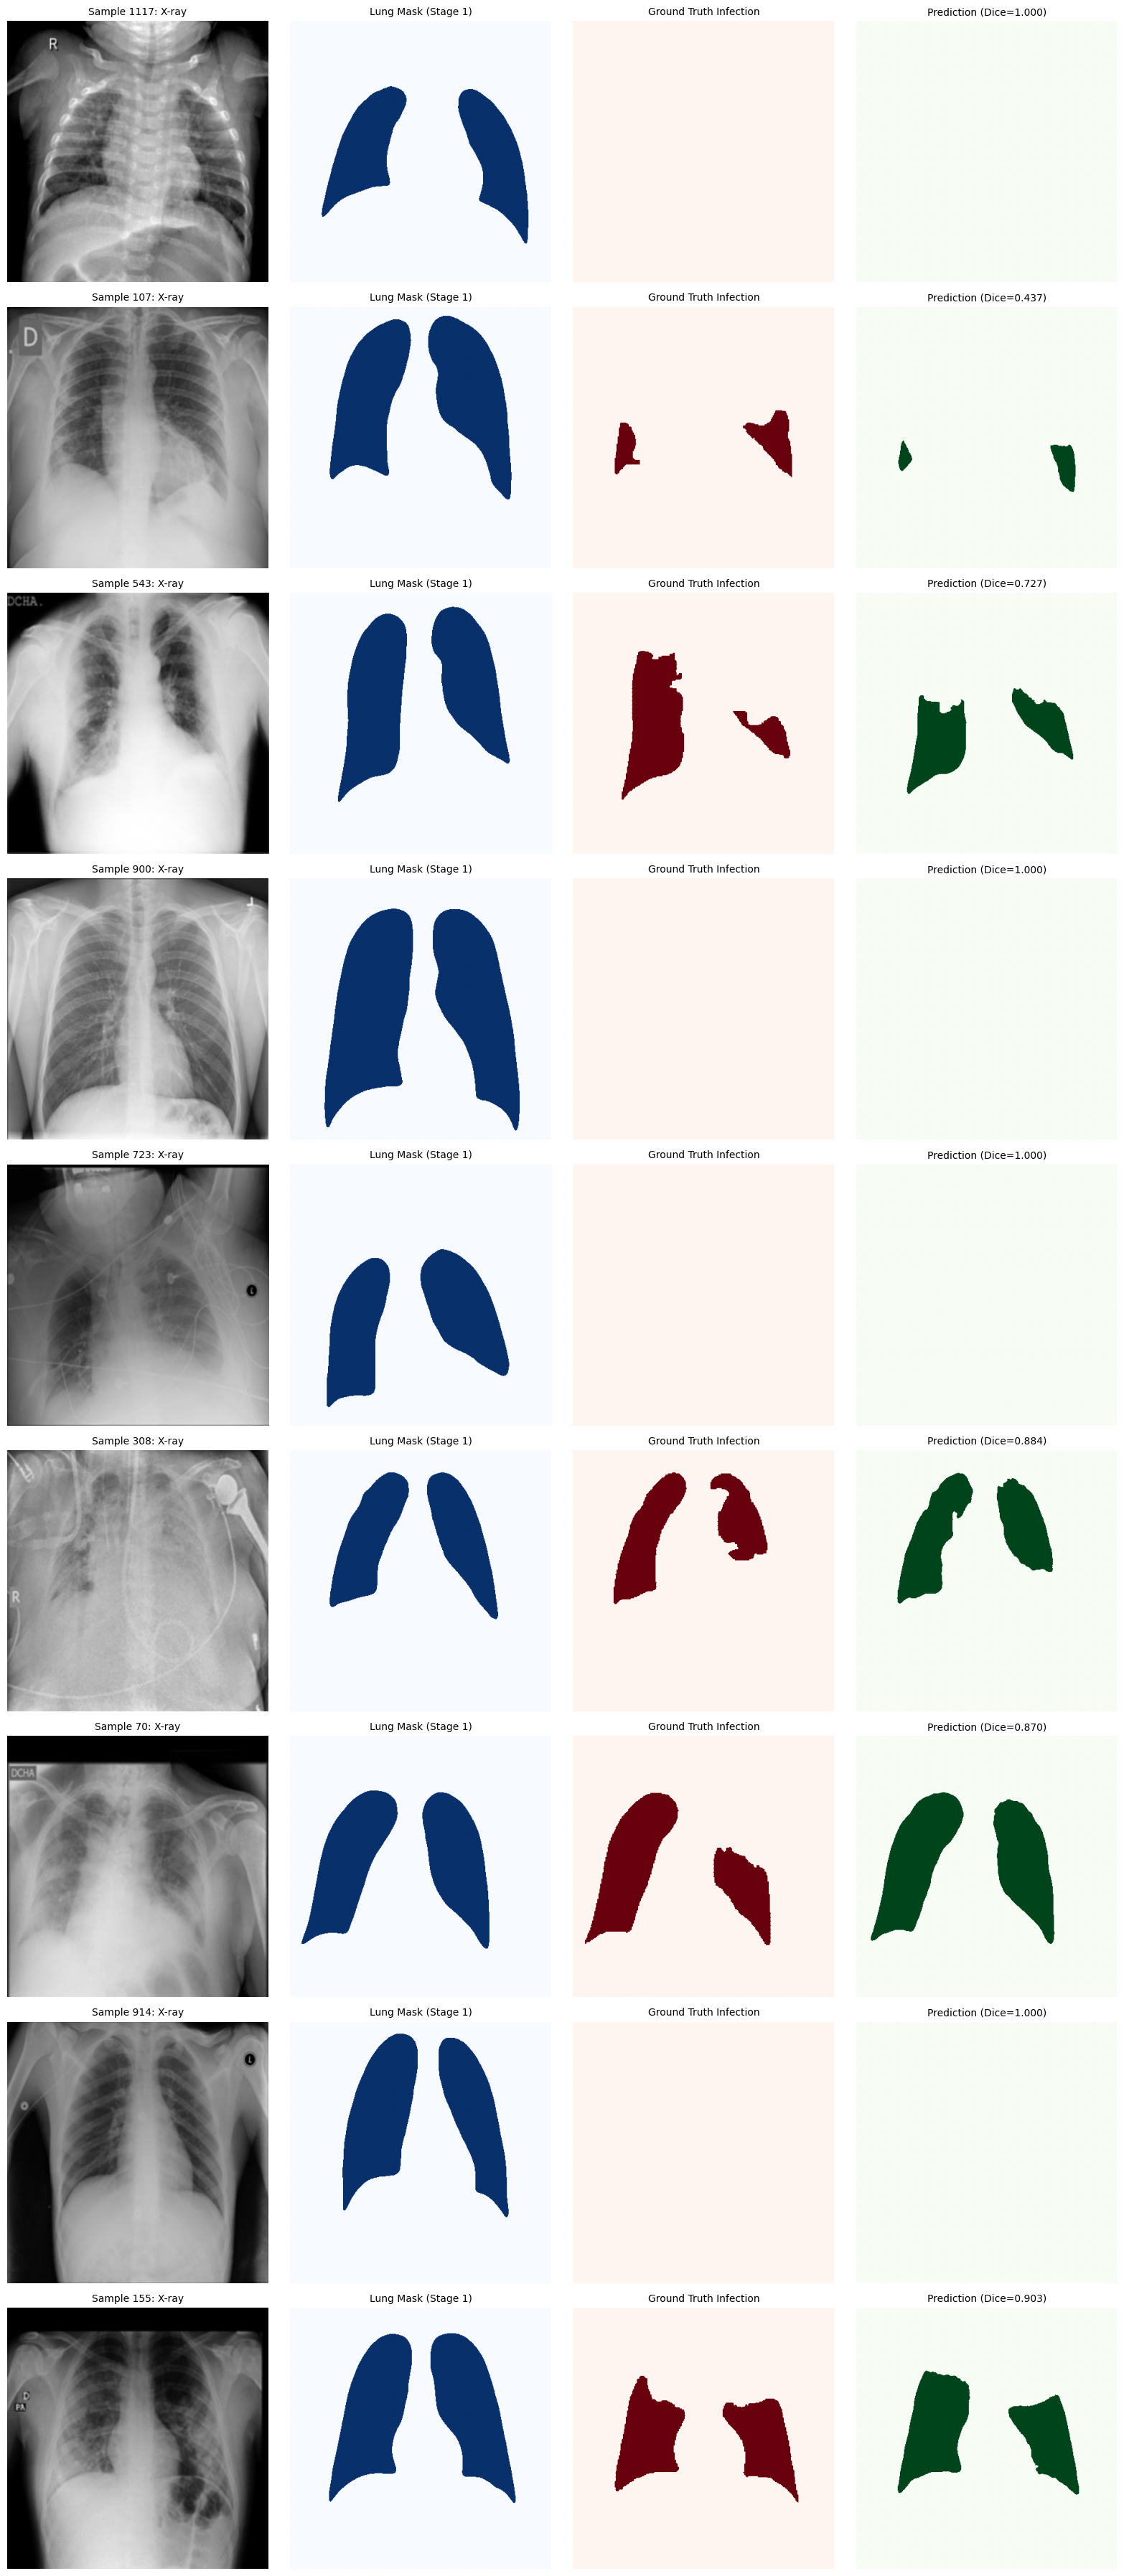

In [ ]:
# Randomly select 9 test samples
np.random.seed(42)
test_indices = np.random.choice(len(test_dataset), 9, replace=False)

fig, axes = plt.subplots(9, 4, figsize=(16, 36))

for idx, test_idx in enumerate(test_indices):
    image_4ch, mask_gt = test_dataset[test_idx]

    # Extract channels
    image_rgb = image_4ch[:3]
    lung_mask_channel = image_4ch[3]

    # Get prediction
    with torch.no_grad():
        image_input = image_4ch.unsqueeze(0).to(device)
        pred = infection_model(image_input)
        pred_mask = (torch.sigmoid(pred) > 0.5).float().squeeze().cpu()

    # Constrain prediction to lung region
    pred_constrained = pred_mask * lung_mask_channel

    # Normalize image to [0, 1] for display
    image_display = image_rgb.permute(1, 2, 0).numpy()
    image_display = image_display / 255.0  # Convert [0, 255] to [0, 1]

    # Calculate Dice for this sample
    intersection = (pred_constrained * mask_gt.squeeze()).sum()
    union = pred_constrained.sum() + mask_gt.squeeze().sum()
    dice = (2.0 * intersection + 1e-5) / (union + 1e-5)

    # Plot
    axes[idx, 0].imshow(image_display, cmap='gray')
    axes[idx, 0].set_title(f'Sample {test_idx}: X-ray', fontsize=10)
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(lung_mask_channel.numpy(), cmap='Blues')
    axes[idx, 1].set_title('Lung Mask (Stage 1)', fontsize=10)
    axes[idx, 1].axis('off')

    axes[idx, 2].imshow(mask_gt.squeeze().numpy(), cmap='Reds')
    axes[idx, 2].set_title('Ground Truth Infection', fontsize=10)
    axes[idx, 2].axis('off')

    axes[idx, 3].imshow(pred_constrained.numpy(), cmap='Greens')
    axes[idx, 3].set_title(f'Prediction (Dice={dice:.3f})', fontsize=10)
    axes[idx, 3].axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/predict.png', dpi=300, bbox_inches='tight')
plt.show()